In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def MSE(p_y_true, p_y_pred):
    return np.mean((p_y_pred - p_y_true) ** 2)

def MSE_der(p_y_true, p_y_pred):
    return 2 / len(p_y_pred) * (p_y_pred - p_y_true)

In [3]:
class Layer:
    def __init__(self, p_in, p_out, p_activation="sigmoid", p_method="unif"):
        #
        self.x = 0
        #
        self.z = 0
        
        #
        n = p_in + p_out
        
        #
        w_shape = (p_in, p_out)
        #
        b_shape = (1, p_out)
        
        #
        match p_method:
            case "unif":
                self.weights = np.random.uniform(0, 1, size=w_shape)
            case "Xavier":
                a = np.sqrt(6 / n)
                self.weights = np.random.uniform(-a, a, size=w_shape)
            case "He":
                self.weights = np.random.normal(0, np.sqrt(2 / n), size=w_shape)
            case _:
                raise Exception("unknown weights initialisation method name")
        #
        self.biases = np.zeros(shape=b_shape)
        #
        self.weights_grad = np.zeros(shape=w_shape)
        #
        self.biases_grad = np.zeros(shape=b_shape)
        
        #
        self.act, self.act_der = self.retrieve(p_activation)
        
        return
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
        
    @staticmethod
    def sigmoid_der(x):
        s = Layer.sigmoid(x)
        
        return s * (1 - s)
        
    @staticmethod
    def linear(x):
        return x
        
    @staticmethod
    def linear_der(x):
        return np.ones(shape=x.shape)
    
    def retrieve(self, p_function_name):
        match p_function_name:
            case "sigmoid":
                return Layer.sigmoid, Layer.sigmoid_der
            case "linear":
                return Layer.linear, Layer.linear_der
            case _:
                raise Exception("unknown activation function name used")
    
    def forward(self, p_input):
        self.x = p_input
        self.z = self.x @ self.weights + self.biases
        
        return self.act(self.z)
    
    def dump(self):
        print("weights:")
        print(self.weights)
        print("biases:")
        print(self.biases)
        print("act:")
        print(self.act)
        print("act der:")
        print(self.act_der)

In [4]:
class Network:
    def __init__(self, p_layers, p_act, p_out_act, p_method="unif"):
        self.layers = []
        
        for l in range(len(p_layers) - 2):
            self.layers.append(Layer(p_layers[l], p_layers[l + 1], p_act))
        
        self.layers.append(Layer(p_layers[-2], p_layers[-1], p_out_act, p_method))
        
        return
    
    def predict(self, p_input):
        result = p_input
        
        for layer in self.layers:
            result = layer.forward(result)
            
        return result
    
    def train_mini_batch(self, p_x, p_y, p_learning_rate):
        for layer in self.layers:
            layer.weights_grad = np.zeros(shape=layer.weights.shape)
            layer.biases_grad = np.zeros(shape=layer.biases.shape)
        
        for (x, y) in zip(p_x, p_y):
            y_pred = self.predict(x)
            
            delta = MSE_der(y, y_pred) * self.layers[-1].act_der(self.layers[-1].z)
            self.layers[-1].weights_grad -= p_learning_rate * self.layers[-1].x.T @ delta
            self.layers[-1].biases_grad -= p_learning_rate * delta
            
            for l in reversed(range(len(self.layers) - 1)):
                delta = (delta @ self.layers[l + 1].weights.T) * self.layers[l].act_der(self.layers[l].z)
                self.layers[l].weights_grad -= p_learning_rate * self.layers[l].x.T @ delta
                self.layers[l].biases_grad -= p_learning_rate * delta
        
        for layer in self.layers:
            layer.weights += layer.weights_grad / len(p_x)
            layer.biases += layer.biases_grad / len(p_x)
        
        return
    
    def train(self, p_x, p_y, p_epochs, p_learning_rate, p_mini_batch_size):
        costs = []
        
        for e in range(p_epochs):
            indexes = list(range(len(p_x)))
            
            if True:
                np.random.shuffle(indexes)
                
            for k in range(0, len(p_x), p_mini_batch_size):
                mini_batch_indexes = indexes[k:k + p_mini_batch_size]
                
                self.train_mini_batch(p_x[mini_batch_indexes], p_y[mini_batch_indexes], p_learning_rate)
            
            costs.append(MSE(p_y, self.predict(p_x)))
        
        return costs
    
    def dump(self):
        for l in range(len(self.layers)):
            print(f"layer {l}")
            self.layers[l].dump()
            print()

## square-simple

In [5]:
square_simple_train = pd.read_csv('mio1/regression/square-simple-training.csv', index_col=0)
square_simple_test = pd.read_csv('mio1/regression/square-simple-test.csv', index_col=0)

In [6]:
square_simple_X_train = square_simple_train.drop(columns='y')
square_simple_y_train = square_simple_train['y']

square_simple_X_test = square_simple_test.drop(columns='y')
square_simple_y_test = square_simple_test['y']

sq_sim_X_train = square_simple_X_train.to_numpy().reshape((square_simple_X_train.shape[0], 1))
sq_sim_y_train = square_simple_y_train.to_numpy().reshape((square_simple_y_train.shape[0], 1))

sq_sim_X_test = square_simple_X_test.to_numpy().reshape((square_simple_X_test.shape[0], 1))
sq_sim_y_test = square_simple_y_test.to_numpy().reshape((square_simple_y_test.shape[0], 1))

In [7]:
if True:
    x_mean = sq_sim_X_train.mean()
    x_std = sq_sim_X_train.std()

    y_mean = sq_sim_y_train.mean()
    y_std = sq_sim_y_train.std()
else:
    x_mean = 0
    x_std = 1

    y_mean = 0
    y_std = 1

sq_sim_X_train_norm = (sq_sim_X_train - x_mean) / x_std
sq_sim_y_train_norm = (sq_sim_y_train - y_mean) / y_std

sq_sim_X_test_norm = (sq_sim_X_test - x_mean) / x_std

In [8]:
network = Network([1, 5, 1], "sigmoid", "linear", "He")

In [9]:
mses = network.train(sq_sim_X_train_norm, sq_sim_y_train_norm, 2000, 0.1, 10)

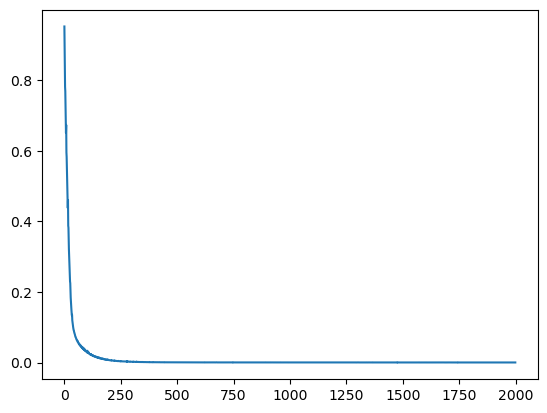

In [10]:
plt.plot(range(len(mses)), mses)

In [11]:
sq_sim_y_train_norm_pred = network.predict(sq_sim_X_train_norm)
sq_sim_y_test_norm_pred = network.predict(sq_sim_X_test_norm)

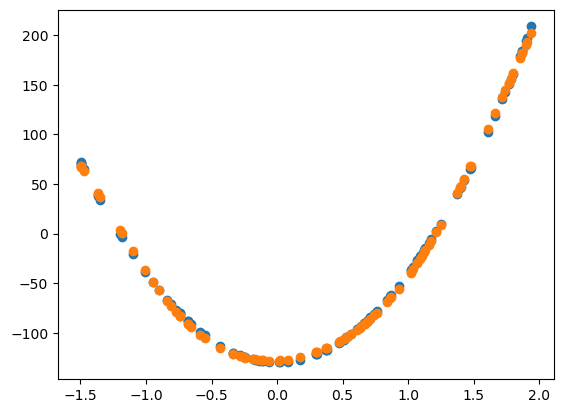

In [12]:
plt.scatter(sq_sim_X_train, sq_sim_y_train)
plt.scatter(sq_sim_X_train, sq_sim_y_train_norm_pred * y_std + y_mean)

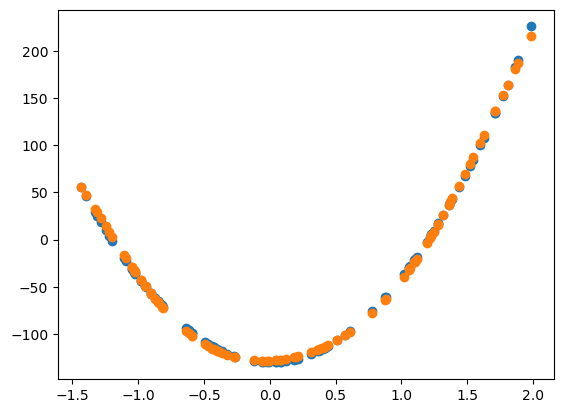

In [13]:
plt.scatter(sq_sim_X_test, sq_sim_y_test)
plt.scatter(sq_sim_X_test, sq_sim_y_test_norm_pred * y_std + y_mean)

In [14]:
print(f"train MSE = {MSE(sq_sim_y_train, sq_sim_y_train_norm_pred * y_std + y_mean)}")
print(f"test MSE  = {MSE(sq_sim_y_test, sq_sim_y_test_norm_pred * y_std + y_mean)}")

train MSE = 5.079470209845227
test MSE  = 5.616481869893257


## steps-small

In [15]:
steps_small_train = pd.read_csv('mio1/regression/steps-small-training.csv', index_col=0)
steps_small_test = pd.read_csv('mio1/regression/steps-small-test.csv', index_col=0)

In [16]:
steps_small_X_train = steps_small_train.drop(columns='y')
steps_small_y_train = steps_small_train['y']

steps_small_X_test = steps_small_test.drop(columns='y')
steps_small_y_test = steps_small_test['y']

st_sm_X_train = steps_small_X_train.to_numpy().reshape((steps_small_X_train.shape[0], 1))
st_sm_y_train = steps_small_y_train.to_numpy().reshape((steps_small_y_train.shape[0], 1))

st_sm_X_test = steps_small_X_test.to_numpy().reshape((steps_small_X_test.shape[0], 1))
st_sm_y_test = steps_small_y_test.to_numpy().reshape((steps_small_y_test.shape[0], 1))

In [17]:
if False:
    x_mean = st_sm_X_train.mean()
    x_std = st_sm_X_train.std()

    y_mean = st_sm_y_train.mean()
    y_std = st_sm_y_train.std()
else:
    x_mean = 0
    x_std = 1

    y_mean = 0
    y_std = 1
    
st_sm_X_train_norm = (st_sm_X_train - x_mean) / x_std
st_sm_y_train_norm = (st_sm_y_train - y_mean) / y_std

st_sm_X_test_norm = (st_sm_X_test - x_mean) / x_std

In [18]:
network = Network([1, 10, 1], "sigmoid", "linear", "He")

In [19]:
mses = network.train(st_sm_X_train_norm, st_sm_y_train_norm, 2000, 0.1, 10)

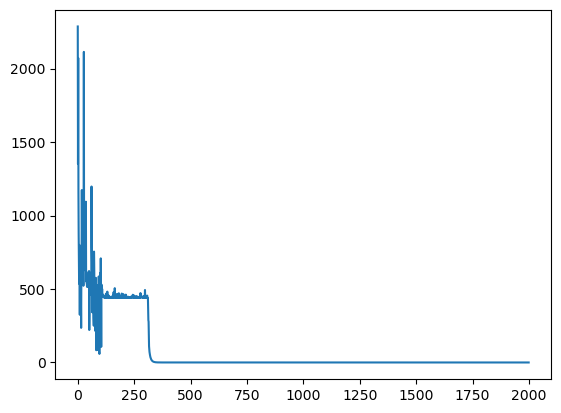

In [20]:
plt.plot(range(len(mses)), mses)

In [21]:
st_sm_y_train_norm_pred = network.predict(st_sm_X_train_norm)
st_sm_y_test_norm_pred = network.predict(st_sm_X_test_norm)

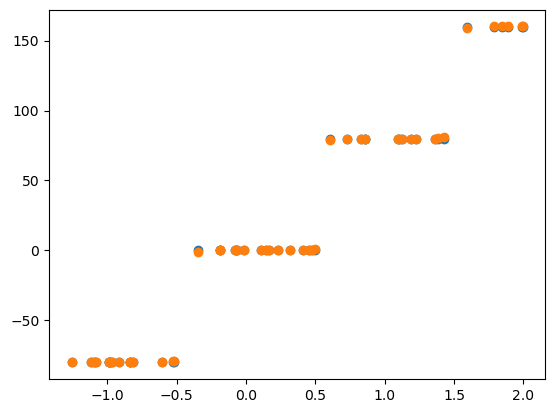

In [22]:
plt.scatter(st_sm_X_train, st_sm_y_train)
plt.scatter(st_sm_X_train, st_sm_y_train_norm_pred * y_std + y_mean)

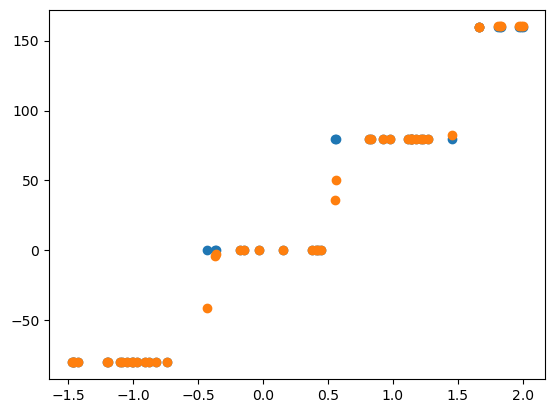

In [23]:
plt.scatter(st_sm_X_test, st_sm_y_test)
plt.scatter(st_sm_X_test, st_sm_y_test_norm_pred * y_std + y_mean)

In [24]:
print(f"train MSE = {MSE(st_sm_y_train, st_sm_y_train_norm_pred * y_std + y_mean)}")
print(f"test MSE  = {MSE(st_sm_y_test, st_sm_y_test_norm_pred * y_std + y_mean)}")

train MSE = 0.11666580946636732
test MSE  = 91.3097265631024


## mutimodal-large

In [25]:
multimodal_large_train = pd.read_csv('mio1/regression/multimodal-large-training.csv')
multimodal_large_test = pd.read_csv('mio1/regression/multimodal-large-test.csv')

In [26]:
multimodal_large_X_train = multimodal_large_train.drop(columns='y')
multimodal_large_y_train = multimodal_large_train['y']

multimodal_large_X_test = multimodal_large_test.drop(columns='y')
multimodal_large_y_test = multimodal_large_test['y']

mul_lr_X_train = multimodal_large_X_train.to_numpy().reshape((multimodal_large_X_train.shape[0], 1))
mul_lr_y_train = multimodal_large_y_train.to_numpy().reshape((multimodal_large_y_train.shape[0], 1))

mul_lr_X_test = multimodal_large_X_test.to_numpy().reshape((multimodal_large_X_test.shape[0], 1))
mul_lr_y_test = multimodal_large_y_test.to_numpy().reshape((multimodal_large_y_test.shape[0], 1))

In [27]:
if True:
    x_mean = mul_lr_X_train.mean()
    x_std = mul_lr_X_train.std()

    y_mean = mul_lr_y_train.mean()
    y_std = mul_lr_y_train.std()
else:
    x_mean = 0
    x_std = 1

    y_mean = 0
    y_std = 1

mul_lr_X_train_norm = (mul_lr_X_train - x_mean) / x_std
mul_lr_y_train_norm = (mul_lr_y_train - y_mean) / y_std

mul_lr_X_test_norm = (mul_lr_X_test - x_mean) / x_std

In [45]:
network = Network([1, 5, 5, 1], "sigmoid", "linear", "He")

In [ ]:
mses = network.train(mul_lr_X_train_norm, mul_lr_y_train_norm, 2000, 0.01, 100)

In [ ]:
plt.plot(range(len(mses)), mses)

In [38]:
mul_lr_y_train_norm_pred = network.predict(mul_lr_X_train_norm)
mul_lr_y_test_norm_pred = network.predict(mul_lr_X_test_norm)

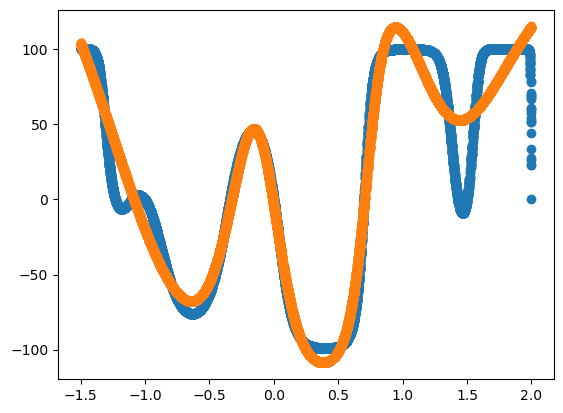

In [39]:
plt.scatter(mul_lr_X_train, mul_lr_y_train)
plt.scatter(mul_lr_X_train, mul_lr_y_train_norm_pred * y_std + y_mean)

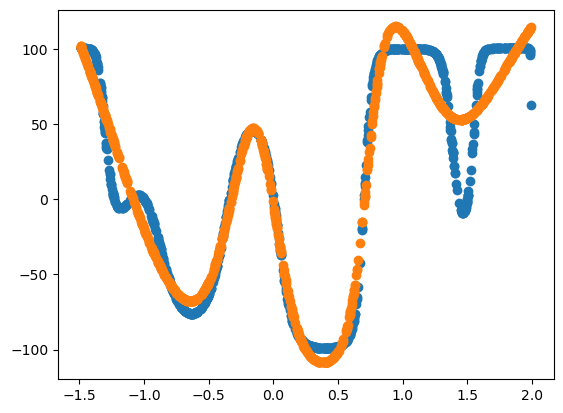

In [40]:
plt.scatter(mul_lr_X_test, mul_lr_y_test)
plt.scatter(mul_lr_X_test, mul_lr_y_test_norm_pred * y_std + y_mean)

In [41]:
print(f"train MSE = {MSE(mul_lr_y_train, mul_lr_y_train_norm_pred * y_std + y_mean)}")
print(f"test MSE  = {MSE(mul_lr_y_test, mul_lr_y_test_norm_pred * y_std + y_mean)}")

train MSE = 308.33115329713803
test MSE  = 314.2564423869769
